In [81]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
import torch.optim as optim
from torchvision.transforms import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from DataSet import WaterTemperatureDataSet, visualize_tensor, visualize_target

import pandas as pd
import datetime

In [82]:
folder = "DataSets" 
WTA1_Dataset = pd.read_csv(folder + "\WTA1_DataSet.csv")

WTA1_Dataset.drop(["location"], axis=1, inplace=True)
WTA1_Dataset

,Date,Water_Avg,Water_Min,Water_Max,year,DataType,Air_Avg,Air_Min,Air_Max,season,TimeSeries
0,1991-01-01,280.00,279.90,280.20,1991,0.0,278.858750,276.71,282.89,1,1
1,1991-01-02,280.40,280.10,280.80,1991,0.0,283.542917,283.21,284.79,1,1
2,1991-01-03,281.10,280.80,281.40,1991,0.0,283.259583,280.05,283.77,1,1
3,1991-01-04,281.20,280.90,281.40,1991,0.0,279.304167,275.25,280.26,1,1
4,1991-01-05,280.80,280.70,280.90,1991,0.0,278.867083,277.89,281.05,1,1
...,...,...,...,...,...,...,...,...,...,...,...
39050,1914-12-27,276.95,276.91,277.00,1914,0.0,276.600000,273.30,279.90,1,107
39051,1914-12-28,277.14,276.98,277.31,1914,0.0,283.050000,279.30,286.80,1,107
39052,1914-12-29,277.05,276.93,277.18,1914,0.0,276.550000,273.10,280.00,1,107
39053,1914-12-30,277.06,276.92,277.20,1914,0.0,274.100000,271.30,276.90,1,107


In [83]:
Data = WaterTemperatureDataSet(WTA1_Dataset, target_cols=["Water_Avg"], numerical_cols=['Air_Min', 'Air_Max', "Air_Avg", 'season'], 
                                categorical_cols=[""], discriminator_col="TimeSeries")

X_train, y_train, X_test, y_test = Data.preprocessor()

In [84]:
def wiewer(X, y): 
    days = np.arange(0, 365)

    plt.plot(days, X['Air_Avg'])
    plt.fill_between(days, X['Air_Avg'], X['Air_Max'], color='red', alpha=0.5)
    plt.fill_between(days, X['Air_Avg'], X['Air_Min'], color='green', alpha=0.5)
    plt.xlabel('days of an unspecified year')
    plt.ylabel('Air Temperature')
    plt.show()

    plt.plot(days, y['Water_Avg'])
    plt.xlabel('days of an unspecified year')
    plt.ylabel('Water Temperature')
    plt.show()


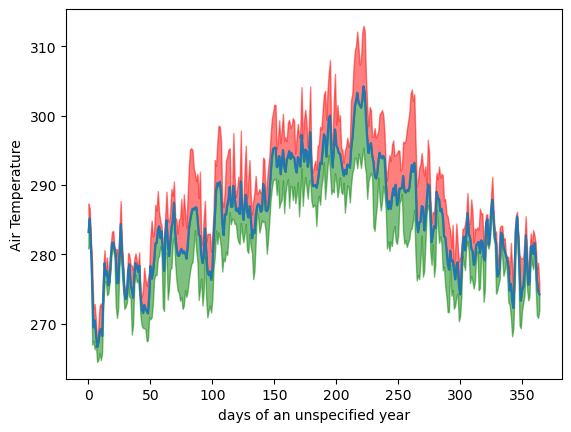

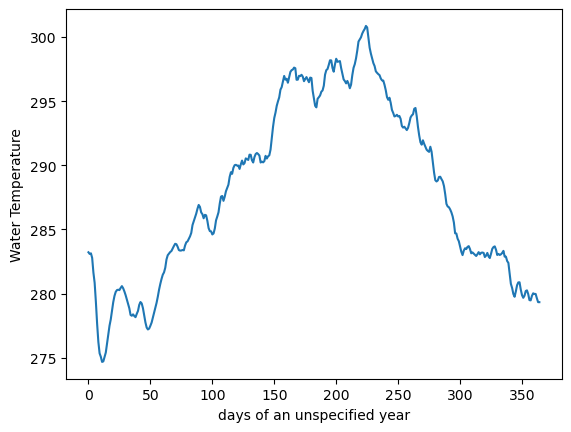

In [85]:
wiewer(X_train[4], y_train[4])

In [86]:
train_iter, test_iter = Data.get_loaders()

In [87]:
train_iterator = train_iter._get_iterator()
test_iterator = test_iter._get_iterator()

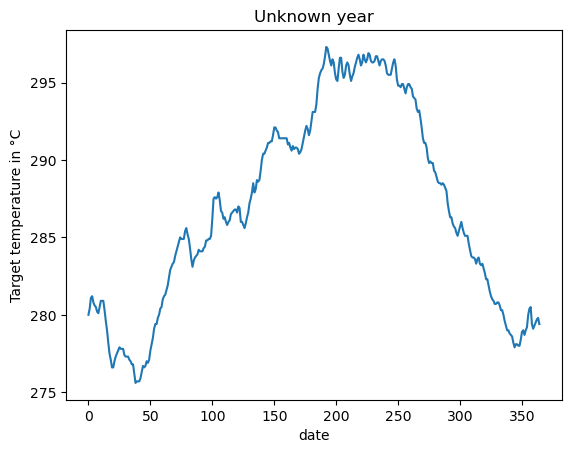

number of points:  365
tensor([[276.7100, 282.8900, 278.8588],
        [283.2100, 284.7900, 283.5429],
        [280.0500, 283.7700, 283.2596],
        ...,
        [272.8100, 277.0900, 274.3033],
        [276.9700, 278.9500, 277.6063],
        [274.8300, 276.8900, 276.6775]])


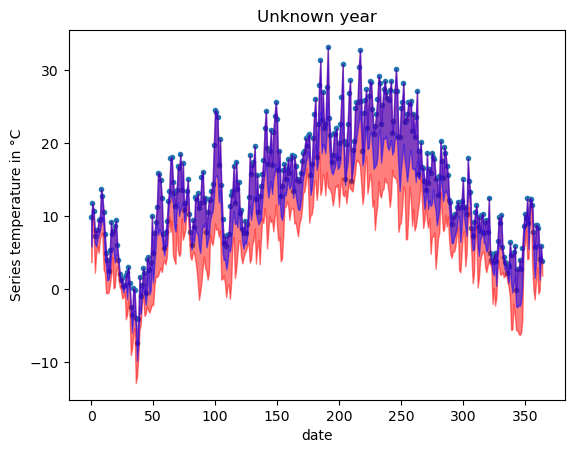

In [88]:
tensors = next(train_iterator)

visualize_target(tensors[1])
visualize_tensor(tensors[0])

In [89]:
from LSTMs import WaterLSTM
from Loss.dilate import dilate_loss 
from Trainer import trainLSTM, plot_prediction

In [90]:
class Simple(nn.Module): 
    def __init__(self, hidden_layers=178):
        super(Simple, self).__init__()
        self.hidden_layers = hidden_layers
        self.l1 = nn.Linear(3, 128)
        self.l2 = nn.Linear(128, 365)
        self.l3 = nn.Linear(365, 1)

    def forward(self, x): 
        x = torch.tanh(self.l1(x))
        x = torch.sigmoid(self.l2(x))
        output = self.l3(x)
        return output

In [91]:
model = Simple()

epochs, total_loss = trainLSTM(model, train_iter, learning_rate=0.01, epochs=100, print_every=10)

epoch  0  loss  7741.39501953125
epoch  10  loss  49.0590705871582
epoch  20  loss  48.41161346435547
epoch  30  loss  48.40477752685547
epoch  40  loss  49.47296142578125
epoch  50  loss  51.75635528564453
epoch  60  loss  51.586570739746094
epoch  70  loss  49.756282806396484
epoch  80  loss  48.73115921020508
epoch  90  loss  48.29343032836914


In [98]:
fill = []
for tensor in total_loss: 
    fill.append(tensor.detach())

[]

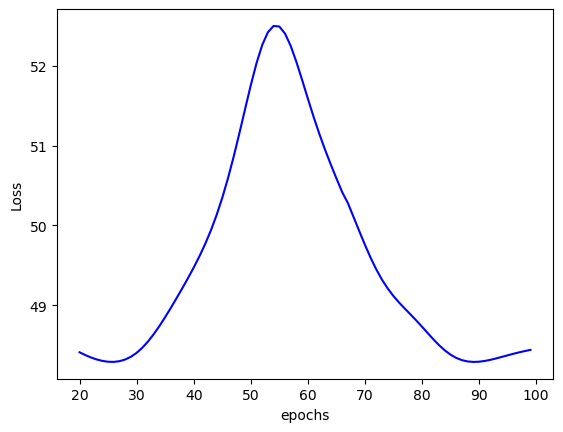

In [101]:
epoch_list = np.arange(0, epochs)

plt.plot(epoch_list[20:], fill[20:], c='blue')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.plot()

In [102]:
model.eval()
test_loss = []

number of points:  365
tensor([[278.9000, 280.7000, 279.8000],
        [274.5000, 277.7000, 276.1000],
        [273.8000, 275.4000, 274.6000],
        ...,
        [278.9000, 279.6000, 279.2500],
        [276.0000, 277.9000, 276.9500],
        [277.0000, 283.3000, 280.1500]])


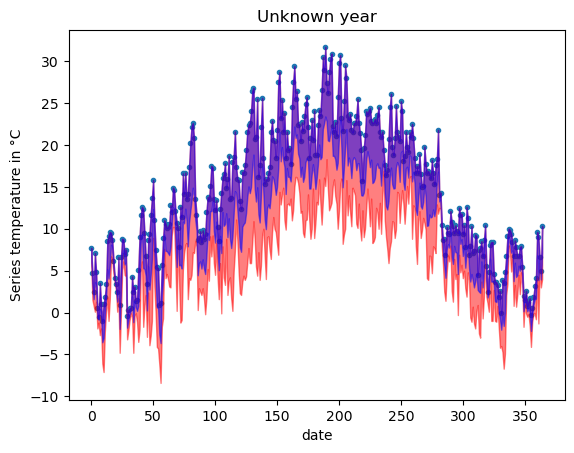

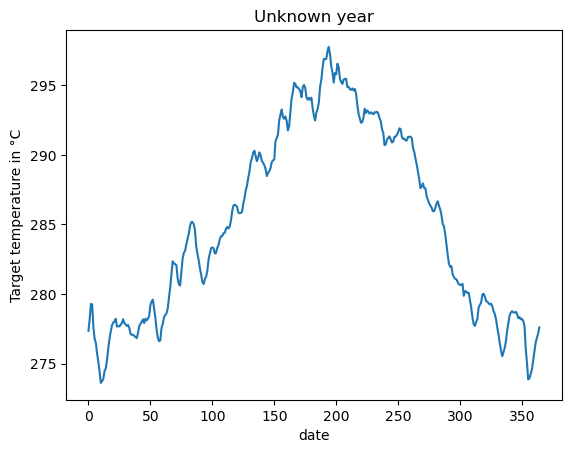

In [104]:
tensors = next(test_iterator)

visualize_tensor(tensors[0])
visualize_target(tensors[1])

In [105]:
loss_function = nn.MSELoss()

def plot_prediction(prediction, target): 
    days = pd.date_range(start="01-01-2030", end="31-12-2030")
    plt.plot(days, prediction- 273, c='green', label="predicted")
    plt.plot(days, target - 273, c='red', label="truth")
    plt.title("Model prediction vs actual data")

    plt.ylabel("Water Tempredature")
    plt.xlabel("Days of the year")
    plt.legend()
    plt.show()

C:\Users\guill\AppData\Local\Temp\ipykernel_42928\1537593797.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  days = pd.date_range(start="01-01-2030", end="31-12-2030")


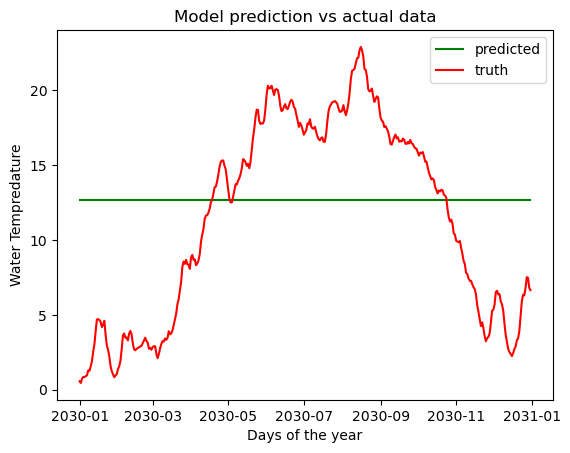

In [118]:
with torch.no_grad():
    tensors = test_iterator.next()
    test, target = tensors[0], tensors[1]
    prediction = model(test)
    loss = loss_function(prediction, target)
    test_loss.append(loss)
    plot_prediction(prediction, target)